# Production planning

In this example  product A represent 'scooter', and product B represents 'Bike'.

--- Simulating one trajectory for each policy ---
Running policy: Greedy (Lowest Inv)
Running policy: Setup-Aware
Running policy: Always Produce Scooter
Running policy: Always Produce Bike
Running policy: Never Switch
Running policy: Random Action


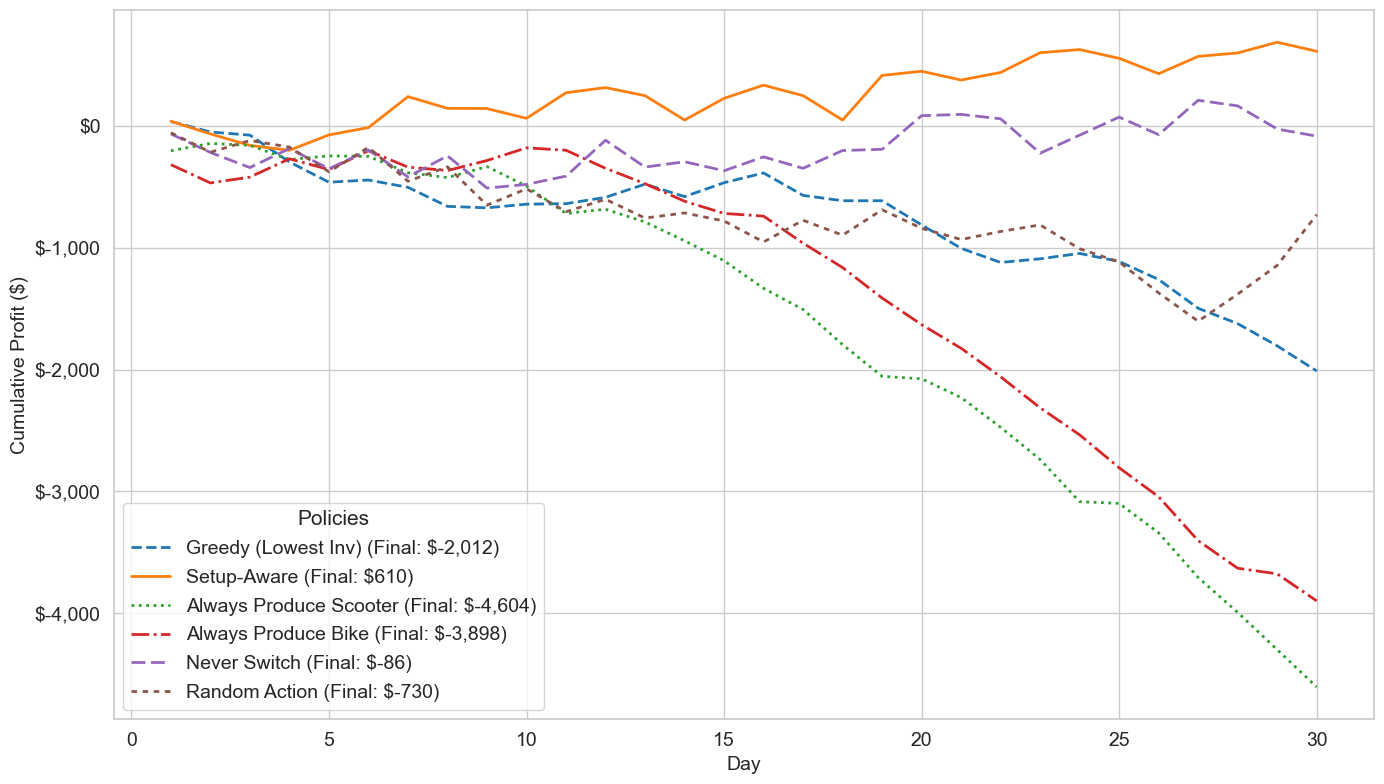


--- Running Simulation (1000 episodes) ---
  Simulating episode 100/1000...
  Simulating episode 200/1000...
  Simulating episode 300/1000...
  Simulating episode 400/1000...
  Simulating episode 500/1000...
  Simulating episode 600/1000...
  Simulating episode 700/1000...
  Simulating episode 800/1000...
  Simulating episode 900/1000...
  Simulating episode 1000/1000...
Simulation complete.

--- Preparing data for visualization ---
--- Generating Plot of Profit Distributions ---


/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_10738/4188483511.py:256: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(


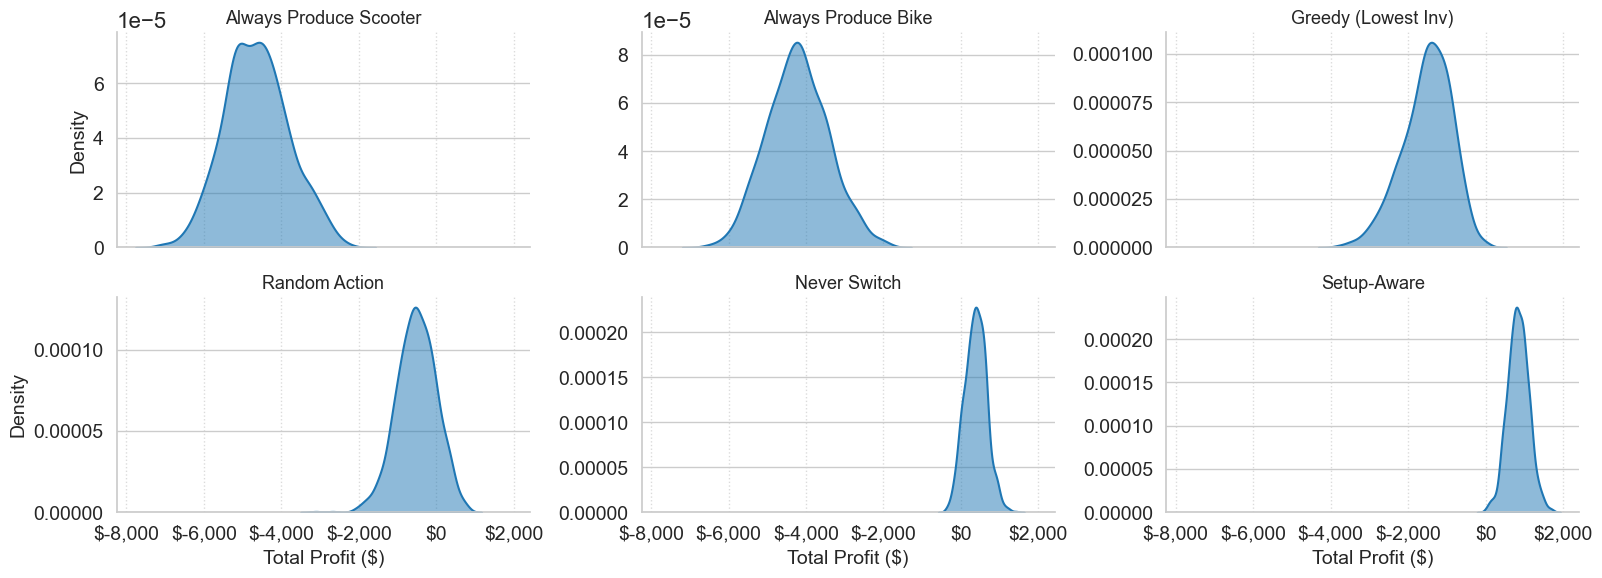


--- Summary Statistics (Total Profit over Horizon) ---
(Based on 1000 simulations, sorted by Mean Profit, Ascending)
----------------------------------------------------------------------
Policy                    | Mean Profit ($) | Std Dev ($)
----------------------------------------------------------------------
Always Produce Scooter    |     -4,639.8 |      831.8
Always Produce Bike       |     -4,221.4 |      792.9
Greedy (Lowest Inv)       |     -1,522.3 |      640.0
Random Action             |       -520.1 |      519.1
Never Switch              |        374.1 |      279.5
Setup-Aware               |        833.3 |      274.5
----------------------------------------------------------------------


In [ ]:
# Required libraries - make sure pandas and seaborn are installed
# pip install numpy matplotlib pandas seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Needed for structuring data for seaborn
import seaborn as sns # Used for styling and plotting
from dataclasses import dataclass
import collections
import warnings

# Suppress specific warnings if necessary (e.g., tight_layout adjustments)
warnings.filterwarnings("ignore", message="Tight layout not applied.*")

# set seed for reproducibility
np.random.seed(1000)

# ------------------ MDP Definition: Factory Production Problem ------------------ #

# --- 1. Parameters ---
@dataclass
class FactoryProblemDefinition:
    """Holds all the fixed parameters of our Factory MDP."""
    lambda_scooter: float = 4.0       # Mean daily demand for scooters (Poisson lambda)
    lambda_bike: float = 3.0          # Mean daily demand for bikes (Poisson lambda)
    horizon: int = 30                 # Planning horizon in days

    prod_capacity_scooter: int = 8    # Units of scooter produced if machine is set to scooter
    prod_capacity_bike: int = 6       # Units of bike produced if machine is set to bike

    price_scooter: float = 40.0       # Revenue per scooter ($)
    price_bike: float = 50.0          # Revenue per bike ($)
    cost_scooter: float = 20.0        # Production cost per scooter ($)
    cost_bike: float = 25.0           # Production cost per bike ($)

    setup_cost: float = 200.0         # Cost incurred when switching production setup ($)
    holding_cost: float = 2.0         # Cost per unit of inventory held overnight ($)
    backorder_cost: float = 10.0      # Cost per unit of unmet demand (backordered) ($)

# --- 2. State Space (S) ---
# A state is defined by: (current_day, inv_scooter, inv_bike, machine_setup)
# Example initial state: (0, 0, 0, 0) # Day 0, no inventory, machine set for scooter

# --- 3. Action Space (A) ---
# Actions available at each state (decision at the start of the day):
ACTIONS = {0: "Produce scooter", 1: "Produce bike", 2: "Idle"}

# --- 4. Transition Function P(s' | s, a) ---
def sample_demand(params: FactoryProblemDefinition):
    """Samples the stochastic demand for one day."""
    demand_scooter = np.random.poisson(params.lambda_scooter)
    demand_bike = np.random.poisson(params.lambda_bike)
    return demand_scooter, demand_bike

def transition(state, action, demand, params: FactoryProblemDefinition):
    """
    Calculates the next state s' given current state s, action a,
    and the realized demand for the day. Also returns intermediate values
    needed for reward calculation.
    """
    day, inv_scooter, inv_bike, current_setup = state
    demand_scooter, demand_bike = demand

    produced_scooter = params.prod_capacity_scooter if action == 0 else 0
    produced_bike = params.prod_capacity_bike if action == 1 else 0

    inv_scooter += produced_scooter
    inv_bike += produced_bike

    satisfied_scooter = min(inv_scooter, demand_scooter)
    satisfied_bike = min(inv_bike, demand_bike)

    inv_scooter -= satisfied_scooter
    inv_bike -= satisfied_bike

    backorder_scooter = demand_scooter - satisfied_scooter  # Unmet demand for scooters
    backorder_bike = demand_bike - satisfied_bike           # Unmet demand for bikes

    next_setup = action if action in (0, 1) else current_setup
    next_day = day + 1
    next_state = (next_day, inv_scooter, inv_bike, next_setup)

    return next_state, produced_scooter, produced_bike, backorder_scooter, backorder_bike

# --- 5. Reward Function R(s, a, s') ---
def reward_function(state, action, demand, params: FactoryProblemDefinition,
                    produced_scooter, produced_bike, backorder_scooter, backorder_bike, next_state):
    """
    Calculates the immediate reward for the transition.
    """
    _day, _inv_scooter, _inv_bike, current_setup = state
    _next_day, next_inv_scooter, next_inv_bike, _next_setup = next_state
    demand_scooter, demand_bike = demand

    revenue = (demand_scooter - backorder_scooter) * params.price_scooter + \
              (demand_bike - backorder_bike) * params.price_bike
    production_cost = produced_scooter * params.cost_scooter + produced_bike * params.cost_bike
    setup_penalty = params.setup_cost if (action in (0, 1) and action != current_setup) else 0
    holding_penalty = params.holding_cost * (next_inv_scooter + next_inv_bike)
    backorder_penalty = params.backorder_cost * (backorder_scooter + backorder_bike)

    total_reward = revenue - production_cost - setup_penalty - holding_penalty - backorder_penalty

    return total_reward

# ------------------ Policy Definitions (Maps State -> Action) ------------------ #
def greedy_policy(state, params: FactoryProblemDefinition):
    _day, inv_scooter, inv_bike, _setup = state
    if inv_scooter < inv_bike:
        return 0
    elif inv_bike < inv_scooter:
        return 1
    else:
        return 0  # Default to scooter if tied

def setup_aware_policy(state, params: FactoryProblemDefinition):
    _day, inv_scooter, inv_bike, current_setup = state
    safety_stock = 5
    critical_stock = 2
    if current_setup == 0 and inv_scooter < safety_stock:
        return 0
    if current_setup == 1 and inv_bike < safety_stock:
        return 1
    if current_setup == 1 and inv_scooter < critical_stock:
        return 0
    if current_setup == 0 and inv_bike < critical_stock:
        return 1
    return 2

def always_produce_scooter_policy(state, params: FactoryProblemDefinition):
    return 0

def always_produce_bike_policy(state, params: FactoryProblemDefinition):
    return 1

def never_switch_policy(state, params: FactoryProblemDefinition):
    _day, inv_scooter, inv_bike, current_setup = state
    target_stock = 15
    if current_setup == 0:
        return 0 if inv_scooter < target_stock else 2
    else:
        return 1 if inv_bike < target_stock else 2

def random_policy(state, params: FactoryProblemDefinition):
    return np.random.choice([0, 1, 2])

# --- Dictionary of policies for easy access ---
POLICIES = {
    "Greedy (Lowest Inv)": greedy_policy,
    "Setup-Aware": setup_aware_policy,
    "Always Produce Scooter": always_produce_scooter_policy,
    "Always Produce Bike": always_produce_bike_policy,
    "Never Switch": never_switch_policy,
    "Random Action": random_policy
}

# ------------------ Simulation Logic ------------------ #
def simulate_trajectory(initial_state, policy_fn, params: FactoryProblemDefinition):
    """Runs one full simulation (episode) using a given policy."""
    state = initial_state
    daily_rewards = []
    cumulative_rewards = []
    total_profit = 0.0

    while state[0] < params.horizon:
        action = policy_fn(state, params)
        demand = sample_demand(params)
        next_state, prod_scooter, prod_bike, backorder_scooter, backorder_bike = transition(state, action, demand, params)
        reward = reward_function(state, action, demand, params, prod_scooter, prod_bike, backorder_scooter, backorder_bike, next_state)
        daily_rewards.append(reward)
        total_profit += reward
        cumulative_rewards.append(total_profit)
        state = next_state

    return daily_rewards, cumulative_rewards, total_profit

# ------------------ Running Simulations and Visualization ------------------ #

# --- Setup ---
factory_params = FactoryProblemDefinition()
initial_state = (0, 0, 0, 0)  # Start at day 0, no inventory, machine set for scooter
num_episodes = 1000           # Number of simulations for Monte Carlo analysis
currency_symbol = "$"         # Define currency symbol

# Use a seaborn style for better aesthetics. 'whitegrid' is a clean choice.
# Use 'tab10' palette for good color distinction in line plots.
sns.set_theme(style="whitegrid", palette="tab10")

# --- 1. Single Trajectory Illustration ---
print("--- Simulating one trajectory for each policy ---")
plt.figure(figsize=(14, 8))
ax1 = plt.gca()
plt.rcParams.update({
    "ytick.labelsize": 16,
    "xtick.labelsize": 16
})

policy_linestyles = {
    'Greedy (Lowest Inv)': '--',
    'Setup-Aware': '-',
    'Always Produce Scooter': ':',
    'Always Produce Bike': '-.',
    'Never Switch': (0, (5, 2)),
    'Random Action': (0, (2, 2))
}

for name, policy in POLICIES.items():
    print(f"Running policy: {name}")
    _, cumulative, final_profit = simulate_trajectory(initial_state, policy, factory_params)
    ax1.plot(
        range(1, factory_params.horizon + 1),
        cumulative,
        label=f"{name} (Final: {currency_symbol}{final_profit:,.0f})",
        linewidth=2,
        linestyle=policy_linestyles.get(name, '-')
    )

ax1.set_xlabel("Day", fontsize=14)
ax1.set_ylabel(f"Cumulative Profit ({currency_symbol})", fontsize=14)
#ax1.set_title(f"Example Policy Trajectories over {factory_params.horizon}-Day Horizon", fontsize=14, pad=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{currency_symbol}{x:,.0f}'))
ax1.legend(fontsize=14, title="Policies", title_fontsize='15')
plt.tight_layout()
plt.show()

# --- 2. Comparison (Distribution of Total Profits) ---
print(f"\n--- Running Simulation ({num_episodes} episodes) ---")
results = collections.defaultdict(list)

for i in range(num_episodes):
    if (i + 1) % (num_episodes // 10) == 0:
        print(f"  Simulating episode {i+1}/{num_episodes}...")
    for name, policy in POLICIES.items():
        _, _, total_profit = simulate_trajectory(initial_state, policy, factory_params)
        results[name].append(total_profit)

print("Simulation complete.")

# --- 3. Prepare Data ---
print("\n--- Preparing data for visualization ---")
data_list = []
for policy_name, profit_list in results.items():
    for profit in profit_list:
        data_list.append({"Policy": policy_name, "Total Profit": profit})
results_df = pd.DataFrame(data_list)

# --- 4. Plotting the Distribution of Results using Faceted KDE Plots ---
print("--- Generating Plot of Profit Distributions ---")

mean_profits = results_df.groupby("Policy")["Total Profit"].mean().sort_values()
ordered_policies = mean_profits.index.tolist()

num_policies = len(ordered_policies)
num_cols = 3

g = sns.displot(
    data=results_df,
    x="Total Profit",
    col="Policy",
    col_wrap=num_cols,
    col_order=ordered_policies,
    kind="kde",
    fill=True,
    palette="viridis",
    linewidth=1.5,
    alpha=0.5,
    facet_kws={'sharey': False, 'sharex': True},
    height=3,
    aspect=1.8
)

#g.fig.suptitle(f'Distribution of Total {factory_params.horizon}-Day Profit by Policy ({num_episodes} Simulations)',
               #fontsize=16, y=1.03)
g.set_axis_labels(f"Total Profit ({currency_symbol})", "Density", fontsize=14)
g.set_titles("{col_name}", size=13)
g.fig.subplots_adjust(top=0.92)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{currency_symbol}{x:,.0f}'))
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, axis='x', linestyle=':', alpha=0.7)

plt.show()

# --- 5. Printing Summary Statistics ---
print("\n--- Summary Statistics (Total Profit over Horizon) ---")
print(f"(Based on {num_episodes} simulations, sorted by Mean Profit, Ascending)")
print("-" * 70)
print(f"{'Policy':<25s} | Mean Profit ({currency_symbol}) | Std Dev ({currency_symbol})")
print("-" * 70)
for policy_name in ordered_policies:
    totals = results[policy_name]
    mean_profit = np.mean(totals)
    std_dev = np.std(totals)
    print(f"{policy_name:<25s} | {mean_profit: >12,.1f} | {std_dev: >10,.1f}")
print("-" * 70)

